In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
from scipy.stats import ks_2samp
from scipy import interp
from shogun import *
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from scripts import utils
from datetime import datetime, timedelta

import time

# below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

#from xgboost import XGBClassifier

%matplotlib inline
plt.style.use('ggplot')

In [3]:
# SQL database config
sqluser = 'o4nguyen'
dbname = 'MIMIC3'
schema_name = 'mimiciii'
hostname = 'hdsldb.uwaterloo.ca'
port = 5432
pwd = getpass.getpass()

# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=5432, password=pwd)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

········


In [14]:
%%time
query_output = utils.get_query_from_file('sql/firstday-lagged-materialized.sql', con)
query_output.to_csv('./vitals-lagged.csv', index=False)

CPU times: user 1min 14s, sys: 4.27 s, total: 1min 19s
Wall time: 2min 45s


In [15]:
query_output.head()

,timestamp,subject_id,hadm_id,icustay_id,heartrate,hr_1h,hr_mean_6h,hr_min_6h,hr_max_6h,hr_median_6h,...,icu_los,icustay_id_order,dod_hosp,dead,dead_in_1d,dead_in_7d,exclusion_los,exclusion_age,exclusion_first_stay,exclusion_surgical
0,2111-11-07 02:00:00,891,191029,257744,101.0,127.0,100.714286,67.0,127.0,101.0,...,1.4997,1,NaT,0,0,0,0,0,0,0
1,2111-11-07 03:00:00,891,191029,257744,86.0,140.0,104.142857,72.0,140.0,101.0,...,1.4997,1,NaT,0,0,0,0,0,0,0
2,2111-11-07 04:00:00,891,191029,257744,83.0,123.0,91.642857,72.0,123.0,83.0,...,1.4997,1,NaT,0,0,0,0,0,0,0
3,2111-11-07 05:00:00,891,191029,257744,84.0,71.0,84.000000,69.0,123.0,83.0,...,1.4997,1,NaT,0,0,0,0,0,0,0
4,2111-11-07 06:00:00,891,191029,257744,76.0,72.0,83.571429,70.0,116.0,80.0,...,1.4997,1,NaT,0,0,0,0,0,0,0


In [2]:
query_output = pd.read_csv('./vitals-lagged.csv') #, index_col='timestamp') #.dropna().reset_index(drop=True)

query_output = query_output.dropna(subset=['timestamp'], how='any')
query_output= query_output.set_index('timestamp')

query_output.first_careunit = pd.Categorical(query_output.first_careunit)
query_output.gender = pd.Categorical(query_output.gender)
query_output.admission_type = pd.Categorical(query_output.admission_type)

query_output['gender'] = query_output.gender.cat.codes
query_output['first_careunit'] = query_output.first_careunit.cat.codes
query_output['admission_type'] = query_output.admission_type.cat.codes

query_output = query_output[(query_output.exclusion_los == 0) & (query_output.exclusion_age == 0) 
                            & (query_output.exclusion_first_stay == 0) ]#& (query_output.age_icu_in < 250)]

# Median age of patients > 89 is 91.6
query_output.loc[query_output.age_icu_in > 89, 'age_icu_in'] = 91.6

mortality_names = ['hospital_expire_flag', 'icu_expire_flag', 
                   'dod_hosp', 'dead_in_1d', 'dead_in_7d']

# Demographic information
demographics =  ['subject_id', 'age_icu_in', 'gender', 
                 'first_careunit', 'admission_type']

feature_names = [
    # Vital signs
    'heartrate', 'hr_1h', 'hr_mean_6h', 'hr_median_6h', 'hr_max_6h', 'hr_min_6h',
    'diasbp', 'diasbp_1h', 'diasbp_mean_6h', 'diasbp_median_6h', 'diasbp_max_6h', 'diasbp_min_6h',
    'sysbp', 'sysbp_1h', 'sysbp_mean_6h', 'sysbp_median_6h', 'sysbp_max_6h', 'sysbp_min_6h',
    'meanbp', 'meanbp_1h', 'meanbp_mean_6h', 'meanbp_median_6h', 'meanbp_max_6h', 'meanbp_min_6h',
    'resprate', 'resprate_1h', 'resprate_mean_6h', 'resprate_median_6h', 'resprate_max_6h', 'resprate_min_6h',
    'tempc', 'tempc_1h', 'tempc_mean_6h', 'tempc_median_6h', 'tempc_max_6h', 'tempc_min_6h',
    'spo2', 'spo2_1h', 'spo2_mean_6h', 'spo2_median_6h', 'spo2_max_6h', 'spo2_min_6h'
]

query_output = query_output.loc[:, mortality_names + demographics + feature_names]
query_output = query_output.fillna(query_output.mean())
query_output.index = pd.to_datetime(query_output.index)

# Remove points after a patient has already died
will_die = (~query_output.dod_hosp.isnull())
point_after_dead = (query_output.index > pd.DatetimeIndex(query_output.dod_hosp))

query_output = query_output.loc[~(will_die & point_after_dead)]


#query_output = query_output.loc[:, mortality_names + feature_names].dropna().reset_index(drop=True) # drop NaNs

df_labels = query_output.loc[:, mortality_names]
df_features = query_output.loc[:, query_output.columns.difference(mortality_names)]

df_features.head()

,admission_type,age_icu_in,diasbp,diasbp_1h,diasbp_max_6h,diasbp_mean_6h,diasbp_median_6h,diasbp_min_6h,first_careunit,gender,...,sysbp_max_6h,sysbp_mean_6h,sysbp_median_6h,sysbp_min_6h,tempc,tempc_1h,tempc_max_6h,tempc_mean_6h,tempc_median_6h,tempc_min_6h
timestamp,,,,,,,,,,,,,,,,,,,,,
2111-11-07 02:00:00,1,37.446714,54.0,60.534578,73.0,60.800000,60.0,46.0,2,0,...,156.0,128.600000,119.0,107.0,37.388891,36.945153,37.799999,37.594445,37.594445,37.388891
2111-11-07 03:00:00,1,37.446714,60.0,60.534578,84.0,64.000000,60.0,49.0,2,0,...,169.0,131.000000,127.0,107.0,36.978712,36.945153,37.799999,37.594445,37.594445,37.388891
2111-11-07 04:00:00,1,37.446714,56.0,57.000000,77.5,60.928571,60.0,49.0,2,0,...,166.0,130.571429,132.0,102.0,36.978712,36.945153,38.000001,37.900000,37.900000,37.799999
2111-11-07 05:00:00,1,37.446714,50.0,49.000000,61.0,54.000000,53.5,49.0,2,0,...,188.0,130.428571,131.0,96.0,36.978712,37.799999,37.799999,37.455555,37.566665,36.888889
2111-11-07 06:00:00,1,37.446714,40.5,49.000000,80.0,59.785714,61.0,40.5,2,0,...,182.0,134.857143,128.0,94.0,36.777778,37.799999,37.799999,37.288889,37.288889,36.777778


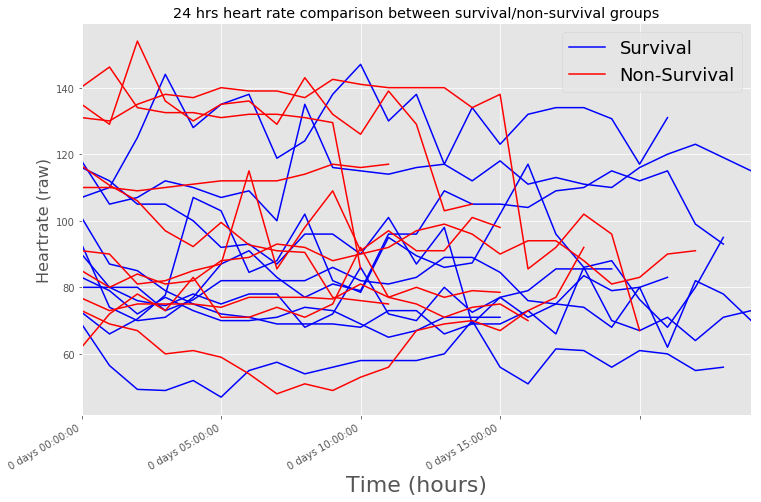

In [6]:
survival = df_features.loc[df_labels.dead_in_1d == 0]
non_survival = df_features.loc[df_labels.dead_in_1d != 0]

surv_rows = np.random.choice(survival.subject_id.values, 10)
non_surv_rows = np.random.choice(non_survival.subject_id.values, 10)

survival = survival.loc[survival.subject_id.isin(surv_rows)]
non_survival = non_survival.loc[non_survival.subject_id.isin(non_surv_rows)]

fig, ax = plt.subplots(figsize=(12, 8))

for title, group in survival.groupby('subject_id'):    
    group.plot(y='heartrate', x=group.index - group.index[0], label='survival', ax=ax, color='blue')

for title, group in non_survival.groupby('subject_id'):
    group.plot(y='heartrate', x=group.index - group.index[0], label='non-survival', ax=ax, color='red')    

legend = plt.legend(['Survival', 'Non-Survival'], fontsize=18)
legend.get_lines()[1].set_color('red')
plt.xlabel('Time (hours)', fontsize=22)
plt.ylabel('Heartrate (raw)', fontsize=16)
plt.title('24 hrs heart rate comparison between survival/non-survival groups')
plt.show()

In [7]:
X = df_features.drop('subject_id', axis=1).reset_index(drop=True)
y = df_labels['dead_in_1d'].reset_index(drop=True)

split = int(len(X) * 0.5)

idx = np.random.permutation(np.arange(len(y)))
train_idx = idx[:split]
test_idx = idx[split:]

X_train = RealFeatures(np.array(X.loc[train_idx].T))
X_test = RealFeatures(np.array(X.loc[test_idx].T))

y_train = MulticlassLabels(np.array(y.loc[train_idx]).astype(np.float))
y_test = MulticlassLabels(np.array(y.loc[test_idx]).astype(np.float))

print("Number of training samples:", y_train.get_num_labels())
print("Number of testing samples:", y_test.get_num_labels())

preprocessor = PruneVarSubMean(True)
preprocessor.init(X_train)
X_train.add_preprocessor(preprocessor)
X_train.apply_preprocessor(True)

preprocessor.init(X_test)
X_test.add_preprocessor(preprocessor)
X_test.apply_preprocessor(True)

('Number of training samples:', 362779)
('Number of testing samples:', 362779)


True

## SVM

In [8]:
%%time

# Parameters to svm
C = 0.1
epsilon = 0.001

svm = LibLinear(C, X_train, y_train.get_binary_for_class(1))
svm.set_liblinear_solver_type(L2R_L2LOSS_SVC)
svm.set_epsilon(epsilon)

svm.train()

y_pred = svm.apply_binary(X_test)

#use AccuracyMeasure to get accuracy
acc = AccuracyMeasure()
acc.evaluate(y_pred, y_test.get_binary_for_class(1))

accuracy = acc.get_accuracy() * 100
print('Accuracy(%):', accuracy)

roc = ROCEvaluation()
roc.evaluate(y_pred, y_test.get_binary_for_class(1))

auc = roc.get_auROC()
print("Area under ROC(%):", auc)

('Accuracy(%):', 98.57626819633992)
('Area under ROC(%):', 0.7321788632544415)
CPU times: user 15.9 s, sys: 0 ns, total: 15.9 s
Wall time: 4.29 s


## Random Forest

In [ ]:
%%time
n_trees = 100

feature_types = np.zeros_like(X.columns, dtype=bool)
feature_types[np.where( (X.columns == 'admission_type') | (X.columns == 'first_careunit') |(X.columns == 'gender'))[0]] = True

m_vote = MajorityVote()

rand_forest = RandomForest(X_train, y_train, n_trees)
rand_forest.set_combination_rule(m_vote)
rand_forest.set_feature_types(feature_types)

rand_forest.train()

y_pred = rand_forest.apply_binary(X_test)

roc = ROCEvaluation()
roc.evaluate(y_pred, y_test.get_binary_for_class(1))

auc = roc.get_auROC()